[*********************100%***********************]  1 of 1 completed

Original Daily Data Points: 1509
Monthly Data Points: 72


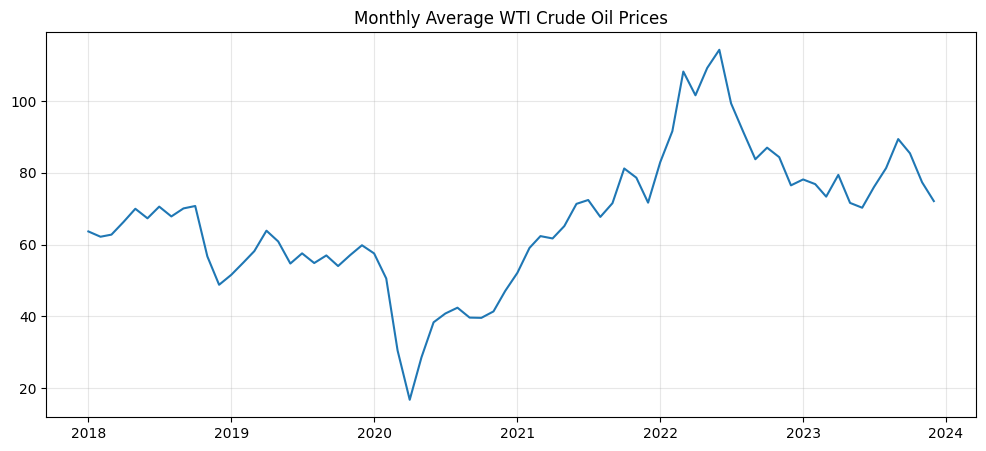

In [ ]:
import yfinance as yf
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings("ignore")

print("Downloading data...")
df = yf.download("CL=F", start="2018-01-01", end="2024-01-01")

df_monthly = df[['Close']].resample('MS').mean()

print(f"Original Daily Data Points: {len(df)}")
print(f"Monthly Data Points: {len(df_monthly)}")

plt.figure(figsize=(12,5))
plt.plot(df_monthly.index, df_monthly['Close'])
plt.title("Monthly Average WTI Crude Oil Prices")
plt.grid(True, alpha=0.3)
plt.show()


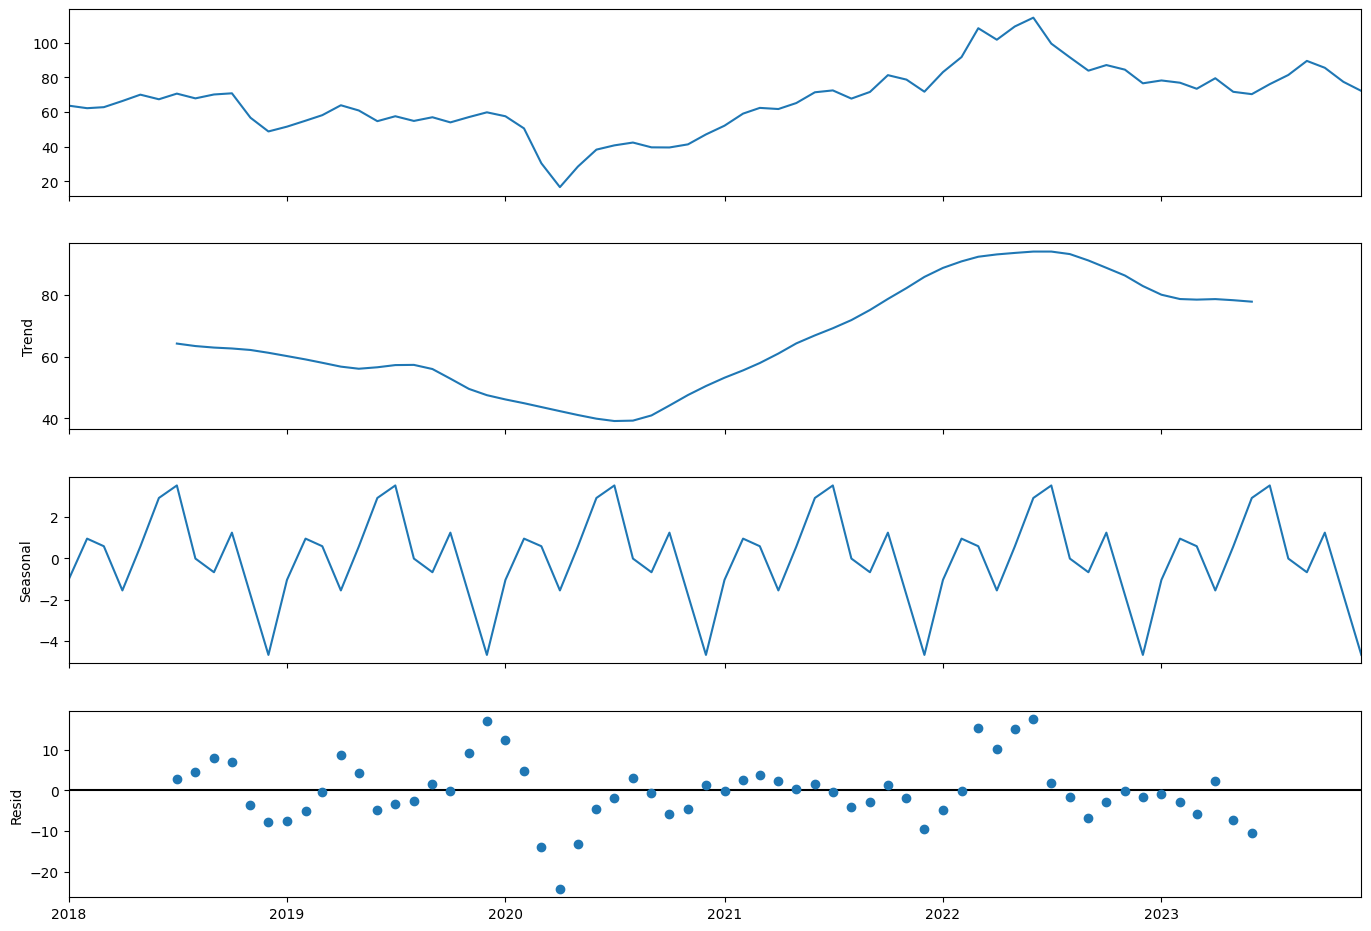

In [8]:
result = seasonal_decompose(df_monthly['Close'], model='additive', period=12)

fig = result.plot()
fig.set_size_inches(15, 10)
plt.show()

In [13]:
from pmdarima import auto_arima

train = df_monthly.iloc[:-12]
test = df_monthly.iloc[-12:]

print("Searching for best SARIMA parameters")

model_auto = auto_arima(
    train['Close'],
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    m=12,
    start_P=0, seasonal=True,
    d=1, D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True
)

print("\nBest Model Found:")
print(model_auto.summary())

Searching for best SARIMA parameters
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=339.790, Time=0.08 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=346.861, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=338.871, Time=0.08 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=335.716, Time=0.10 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=341.036, Time=0.02 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=337.614, Time=0.15 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=337.603, Time=0.18 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=337.267, Time=0.07 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=0.68 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.34 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=337.675, Time=0.11 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=336.771, Time=0.08 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=339.255, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[12] intercept   : AIC=337.574, Time=0.14 sec

Bes

In [15]:
model = SARIMAX(train['Close'], order=model_auto.order, seasonal_order=model_auto.seasonal_order)

model_fit = model.fit(disp=False)

forecast_result = model_fit.get_forecast(steps=len(test))
forecast_mean = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

# 3. Clean up indices for plotting
forecast_mean.index = test.index
conf_int.index = test.index

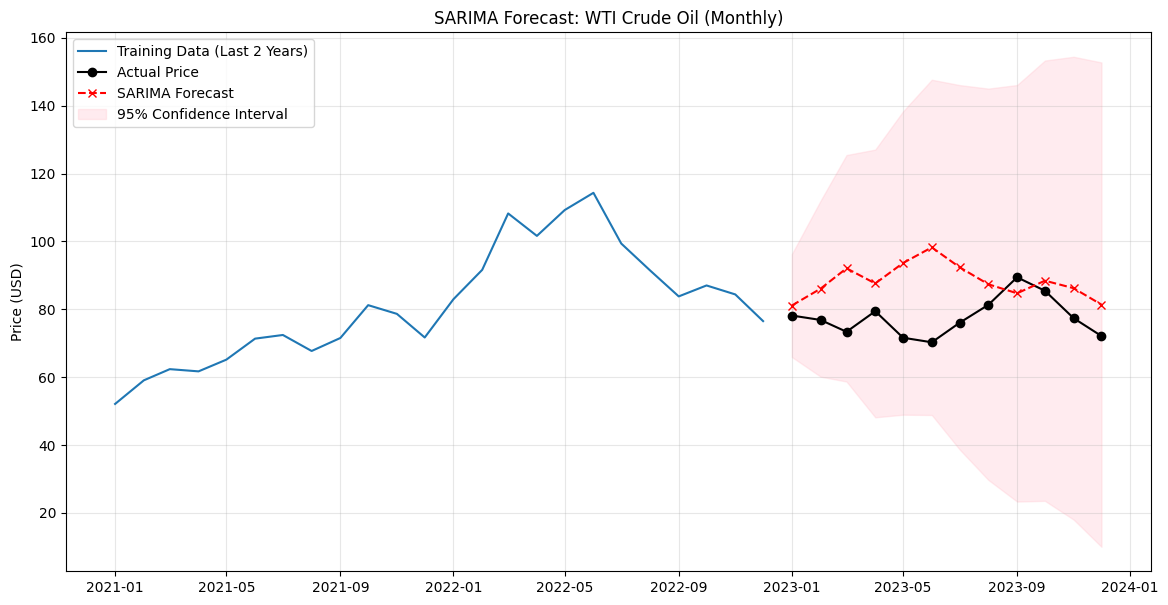

SARIMA RMSE: $13.78


In [16]:
# Plotting
plt.figure(figsize=(14, 7))

# Plot Training Data (Recent history only for clarity)
plt.plot(train.index[-24:], train['Close'][-24:], label='Training Data (Last 2 Years)')

# Plot Actual Test Data
plt.plot(test.index, test['Close'], label='Actual Price', color='black', marker='o')

# Plot SARIMA Forecast
plt.plot(test.index, forecast_mean, label='SARIMA Forecast', color='red', linestyle='--', marker='x')

# Plot Confidence Interval (The Cone)
plt.fill_between(test.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

plt.title('SARIMA Forecast: WTI Crude Oil (Monthly)')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calculate Error
rmse = np.sqrt(mean_squared_error(test['Close'], forecast_mean))
print(f"SARIMA RMSE: ${rmse:.2f}")